In [1]:
import skimage
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
from time import time
import collections
from skimage.measure import label
from skimage.measure import regionprops
%matplotlib inline

In [2]:
treasures = [io.imread('Klad0{}.jpg'.format(i)) for i in xrange(0, 3)]

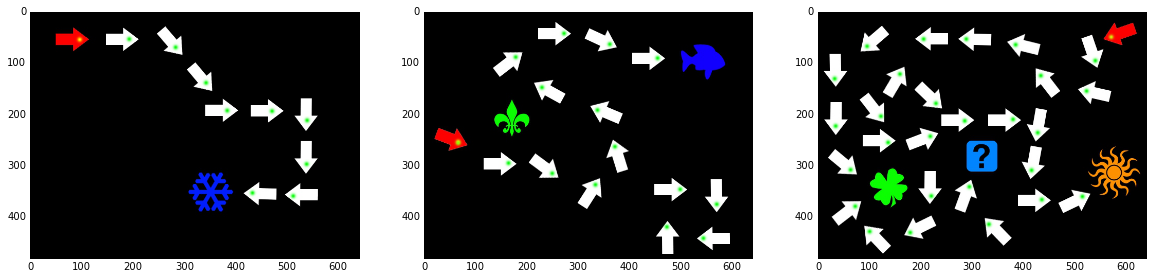

In [3]:
fig, axes = plt.subplots(ncols=len(treasures), figsize=(20,20))
for ax, treasure in zip(axes, treasures):
    ax.imshow(treasure)

# 1

In [4]:
def binarize(image, threshold):
    return 255 * (image > threshold).astype(np.uint8)

In [5]:
gray_treasures = [skimage.color.rgb2gray(treasure) for treasure in treasures]

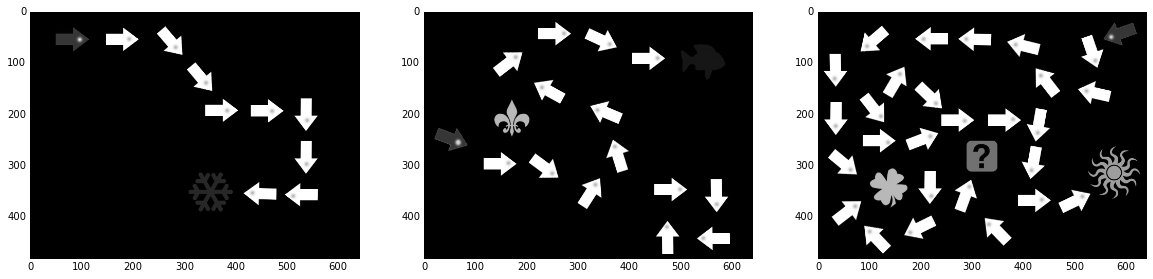

In [6]:
fig, axes = plt.subplots(ncols=len(gray_treasures), figsize=(20,20))
for ax, gray_treasure in zip(axes, gray_treasures):
    ax.imshow(gray_treasure, cmap='gray')

In [7]:
bin_treasures = [binarize(gray_treasure, 0.05) for gray_treasure in gray_treasures]

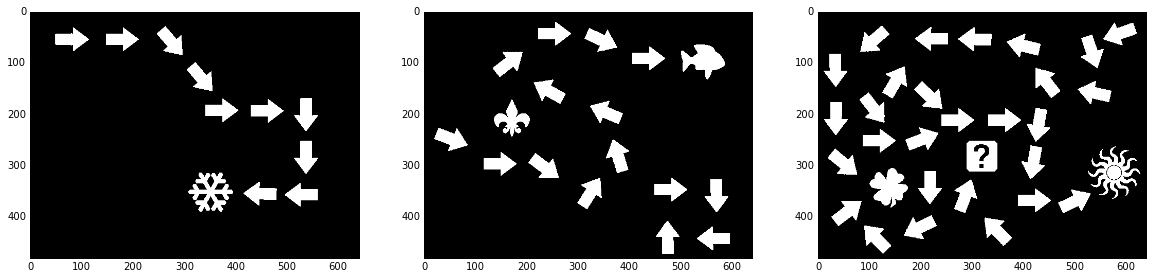

In [8]:
fig, axes = plt.subplots(ncols=len(bin_treasures), figsize=(20,20))
for ax, bin_treasure in zip(axes, bin_treasures):
    ax.imshow(bin_treasure, cmap='gray')

# 2

In [9]:
label_treasures = [skimage.measure.label(bin_treasure) for bin_treasure in bin_treasures]

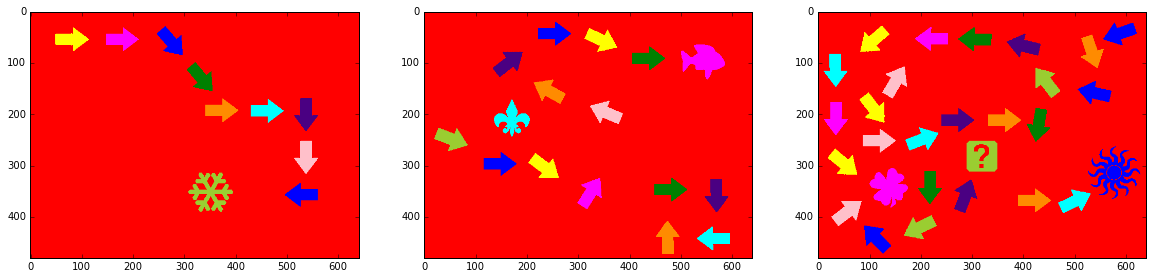

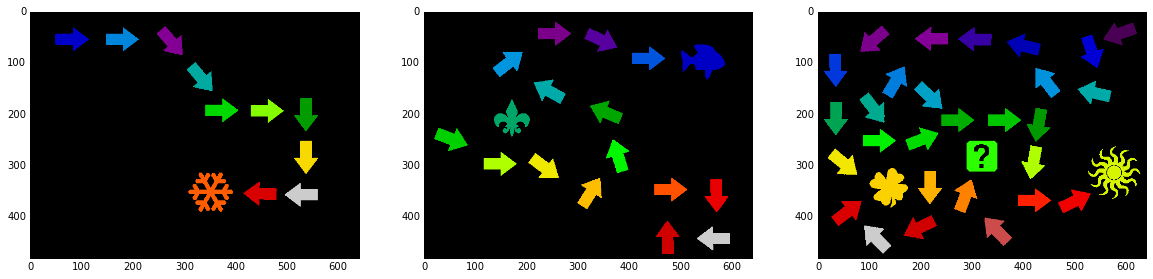

In [10]:
fig, axes = plt.subplots(ncols=len(label_treasures), figsize=(20,20))
for ax, label_treasure in zip(axes, label_treasures):
    ax.imshow(skimage.color.label2rgb(label_treasure))

fig, axes = plt.subplots(ncols=len(label_treasures), figsize=(20,20))
for ax, label_treasure in zip(axes, label_treasures):
    ax.imshow(label_treasure, cmap='nipy_spectral')

Второй вариант дает более симпатичный результат, поэтому в дальнейшем будем использовать именно его

# 3

In [11]:
regions_props = [regionprops(label_treasure) for label_treasure in label_treasures]
for regions_prop in regions_props:
    perimeters = [int(prop.perimeter) for prop in regions_prop]
    perimeters.sort()
    print (perimeters)

[189, 189, 189, 189, 191, 192, 192, 193, 193, 194, 743]
[189, 189, 189, 189, 190, 191, 191, 198, 201, 201, 202, 202, 203, 205, 206, 314, 397]
[189, 189, 189, 189, 190, 191, 191, 191, 191, 196, 197, 198, 198, 198, 198, 199, 199, 200, 201, 201, 201, 201, 202, 203, 204, 204, 204, 205, 359, 396, 1224]


Внимательное наблюдение показывает, что стрелка имеет периметр от $189$ до $206$

In [12]:
def isArrow(prop):
    return 188 <= prop.perimeter <= 207

In [13]:
def replaceWith(region_props, x):
    if x>0 and isArrow(region_props[x - 1]):
        return 1
    return 0

def findArrows(image):
    gray_image = skimage.color.rgb2gray(treasure)
    bin_image = binarize(gray_image, 0.05)
    label_image = skimage.measure.label(bin_image)
    region_props = skimage.measure.regionprops(label_image)
    cleared_label_image = label_image.reshape(label_image.shape[0] * label_image.shape[1])
    cleared_label_image = np.array([replaceWith(region_props, x) for x in cleared_label_image])
    return cleared_label_image.reshape(label_image.shape)

In [14]:
only_arrows_treasures = [findArrows(treasure) for treasure in treasures]

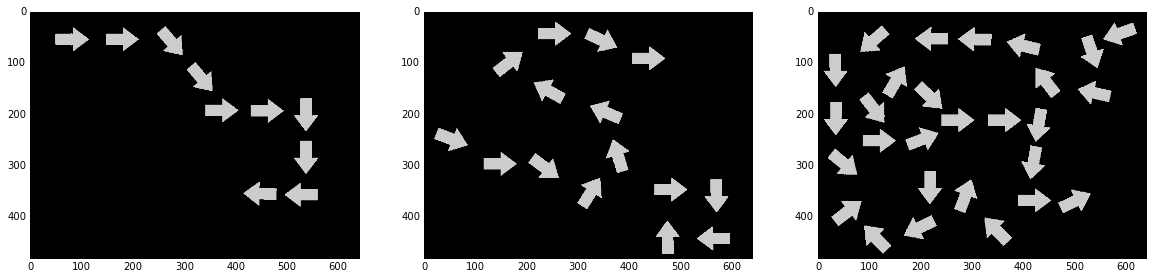

In [15]:
fig, axes = plt.subplots(ncols=len(only_arrows_treasures), figsize=(20,20))
for ax, arrows_treasure in zip(axes, only_arrows_treasures):
    ax.imshow(arrows_treasure, cmap='nipy_spectral')

# 4

In [16]:
def findStart(image, region_props, label_image):
    for i in xrange(image.shape[0]):
        for j in xrange(image.shape[1]):
            if label_image[i][j] == 0:
                continue
            if isArrow(region_props[label_image[i][j] - 1]):
                if image[i][j][0] > 250 and image[i][j][1] + image[i][j][2] < 20:
                    return (i, j)
    

In [17]:
starts = [findStart(treasure, region_props, label_image) for\
         treasure, region_props, label_image in\
         zip(treasures, regions_props, label_treasures)]
print (starts)

/home/aliakseisemchankau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in ubyte_scalars


[(35, 85), (229, 29), (25, 576)]


# 5

In [18]:
def dist(x, y, a, b):
    return ((x - a) ** 2 + (y - b) ** 2) ** (0.5)

In [19]:
def getStraightLine(label, label_image, centroid):
    x = int(centroid[0])
    y = int(centroid[1])
    farth_x = x
    farth_y = y
    for i in xrange(label_image.shape[0]):
        for j in xrange(label_image.shape[1]):
            if label_image[i][j] == label and dist(x, y, i, j) > dist(x, y, farth_x, farth_y):
                farth_x = i
                farth_y = j
    dx = farth_x - x
    dy = farth_y - y
    lenline = (dx**2 + dy**2)**0.5
    return dx / lenline, dy / lenline

In [20]:
def getNextLabel(label, label_image, region_props):
    label_props = region_props[label - 1]
    centroid = label_props.centroid
    dx, dy = getStraightLine(label, label_image, centroid)
    iteration = 0
    x = int(centroid[0])
    y = int(centroid[1])
    while True:
        iteration += 1
        line_x = int(x + iteration * dx)
        line_y = int(y + iteration * dy)
        leiba = label_image[line_x][line_y]
        if leiba != label and leiba != 0:
            return leiba

In [21]:
def replaceTreasure(image, label_image, labels, region_props):
    def replace(x, labels):
        if x == 0:
            return 0
        if x in labels[:-1]:
            return 4
        if x == labels[-1]:
            return 2
        return 1
    
    replaced_label_image = label_image.copy()
    
    for i in xrange(image.shape[0]):
        for j in xrange(image.shape[1]):
            replaced_label_image[i][j] = replace(label_image[i][j], labels)

    return replaced_label_image      

# 6

In [22]:
def findTreasure(image):
    gray_image = skimage.color.rgb2gray(treasure)
    bin_image = binarize(gray_image, 0.05)
    label_image = skimage.measure.label(bin_image)
    region_props = skimage.measure.regionprops(label_image)
    start = findStart(image, region_props, label_image)
    start_label = label_image[start[0]][start[1]]
    labels = [start_label]
    current_label = start_label
    while isArrow(region_props[current_label - 1]):
        current_label = getNextLabel(current_label, label_image, region_props)
        labels.append(current_label)
    replaced_treasures = replaceTreasure(treasure, label_image, labels, region_props)
    return replaced_treasures
    
    

/home/aliakseisemchankau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in ubyte_scalars


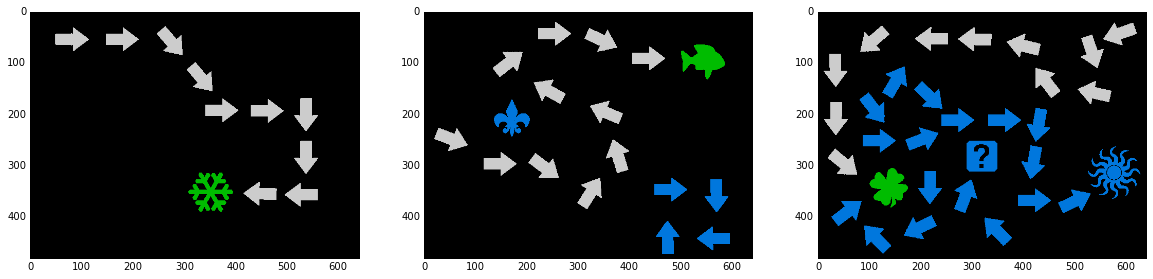

In [23]:
only_treasures = [findTreasure(treasure) for treasure in treasures]

fig, axes = plt.subplots(ncols=len(only_treasures), figsize=(20,20))
for ax, only_treasure in zip(axes, only_treasures):
    ax.imshow(only_treasure, cmap='nipy_spectral')